In [1]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
from sklearn import linear_model as lm, metrics, ensemble as ens
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
import warnings

2024-10-03 13:40:11.162188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("full_info.csv")

df_latest = pd.read_csv("latest_years.csv")

In [3]:
df_opzones = pd.read_csv("opzone_list.csv")

In [4]:
df = pd.get_dummies(df, prefix = 'state', columns = ['state'])
df_latest = pd.get_dummies(df_latest, prefix = 'state', columns = ['state'])

In [5]:
for col in df.columns:
    if 'state' in col:
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [6]:
df_latest = df_latest[df_latest['year'] == df_latest['year'].max()]

In [7]:
opzones = list(set(df_opzones['County'].values.tolist()))
opzones_formatted = [x for x in df_latest['place'] if any(y in x for y in opzones)]
df_latest = df_latest[df_latest['place'].isin(opzones_formatted)]

In [8]:
print('mean current value: ', df_latest['average_home_value'].mean())
print('median current value: ', df_latest['average_home_value'].median())
print('25th percentile current value: ', np.percentile(df_latest['average_home_value'], 25))
print('number 200k or less: ', len(df_latest[df_latest['average_home_value'] <= 200000]))

mean current value:  361946.5698018018
median current value:  302245.34
25th percentile current value:  236493.785
number 200k or less:  70


In [9]:
df_latest_candidates = df_latest.sort_values(by = 'average_home_value').drop(columns = [x for x in df_latest.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and \
                                                                                        # '3' not in x and\
                                        'roi' not in x and 'vacancy' not in x])

df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('California')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('New York')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Puerto Rico')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Hawaii')]
df_latest_candidates = df_latest_candidates[df_latest_candidates['average_home_value'] <= 250000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['total_population'] >= 100000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_1_years'] < 0]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_3_years'] < df_latest_candidates['vacancy_growth_last_2_years']]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_2_years'] < df_latest_candidates['vacancy_growth_last_1_years']] 
df_latest_candidates.sort_values(by = 'vacancy_rate')

,year,average_annual_rent,place,average_home_value,total_population,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years
4295,2022,10077.00,Webb County - Texas,214876.97,267780,0.066400,-0.274451,-0.312893,-0.398654
4177,2022,9995.76,Summit County - Ohio,243907.40,535882,0.067572,-0.057368,-0.144442,-0.237275
4172,2022,9986.76,Montgomery County - Ohio,208866.70,533892,0.068186,-0.320557,-0.375939,-0.425148
3954,2022,9650.40,Black Hawk County - Iowa,214102.22,130274,0.071951,-0.130795,-0.139619,-0.361561
4218,2022,8984.28,Erie County - Pennsylvania,206149.49,267689,0.073566,-0.059963,-0.202974,-0.235928
3930,2022,9316.92,Madison County - Illinois,230026.84,263864,0.076456,-0.003611,-0.185406,-0.231434
3942,2022,8528.40,Delaware County - Indiana,160351.62,112031,0.080454,-0.258178,-0.298912,-0.400547
4019,2022,9311.88,Jackson County - Michigan,218947.34,160066,0.086192,-0.179692,-0.199089,-0.284876
3975,2022,10338.12,Bossier Parish - Louisiana,243277.00,129276,0.097280,-0.176416,-0.295024,-0.338428
4296,2022,9778.08,Wichita County - Texas,184143.64,129978,0.099112,-0.161077,-0.261678,-0.293045


Text(0, 0.5, 'Number of Counties')

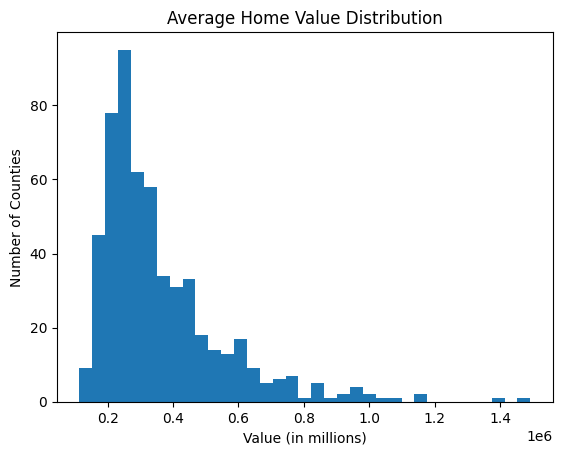

In [10]:
plt.hist(df_latest['average_home_value'], bins = 35)
plt.title("Average Home Value Distribution")
plt.xlabel("Value (in millions)")
plt.ylabel("Number of Counties")


In [11]:
df_latest['vacancy_rate'].mean()

0.09232452947995137

Text(0, 0.5, 'Number of Counties')

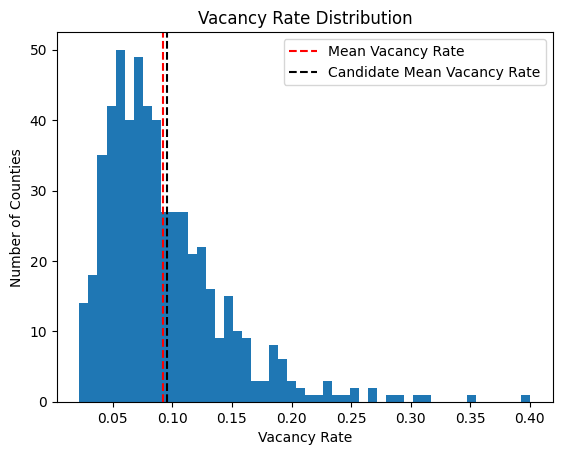

In [12]:
plt.hist(df_latest['vacancy_rate'], bins = 50)
plt.axvline(df_latest['vacancy_rate'].mean(), color = 'r', linestyle = 'dashed', label = 'Mean Vacancy Rate')
plt.axvline(df_latest_candidates['vacancy_rate'].mean(), color = 'k', linestyle = 'dashed', label = 'Candidate Mean Vacancy Rate')
plt.legend()
plt.title("Vacancy Rate Distribution")
plt.xlabel("Vacancy Rate")
plt.ylabel("Number of Counties")


In [13]:
print('mean current vacancy rate: ', df_latest['vacancy_rate'].mean())
print('median current vacancy rate: ', df_latest['vacancy_rate'].median())
print('25th percentile current vacancy rate: ', np.percentile(df_latest['vacancy_rate'], 25))


mean current vacancy rate:  0.09232452947995137
median current vacancy rate:  0.0802365539838567
25th percentile current vacancy rate:  0.05640196145241215


(array([ 7.,  6., 11.,  6., 17., 14., 16., 21., 25., 20., 22., 19., 23.,
        16., 25., 16., 25., 21., 14., 13., 12., 20.,  7., 13., 11., 17.,
         9.,  8.,  6., 14.,  6.,  9.,  3.,  5.,  9.,  7.,  4.,  6.,  2.,
         5.,  3.,  2.,  1.,  2.,  2.,  4.,  3.,  3.,  3.,  3.]),
 array([0.02199413, 0.02553192, 0.0290697 , 0.03260749, 0.03614527,
        0.03968305, 0.04322084, 0.04675862, 0.05029641, 0.05383419,
        0.05737197, 0.06090976, 0.06444754, 0.06798533, 0.07152311,
        0.07506089, 0.07859868, 0.08213646, 0.08567425, 0.08921203,
        0.09274981, 0.0962876 , 0.09982538, 0.10336317, 0.10690095,
        0.11043873, 0.11397652, 0.1175143 , 0.12105209, 0.12458987,
        0.12812765, 0.13166544, 0.13520322, 0.13874101, 0.14227879,
        0.14581657, 0.14935436, 0.15289214, 0.15642993, 0.15996771,
        0.16350549, 0.16704328, 0.17058106, 0.17411885, 0.17765663,
        0.18119441, 0.1847322 , 0.18826998, 0.19180777, 0.19534555,
        0.19888333]),
 <BarContainer

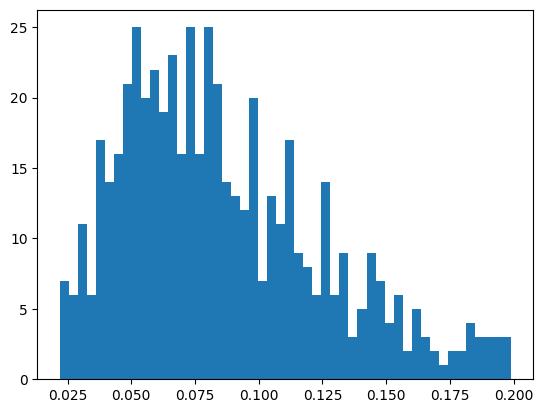

In [14]:
plt.hist(df_latest[df_latest['vacancy_rate'] < 0.2]['vacancy_rate'], bins = 50)

In [15]:
# MAKE VALI DATA SECOND TO LAST YEAR; TEST DATA LAST YEAR; TRAIN FIRST 6
last_year = df['year'].max()
train = df[df['year'] < last_year - 4]
vali = df[df['year'] == last_year - 1]
test = df[df['year'] == last_year]

In [16]:
print('training sample - ', len(train))
print('validation sample - ', len(vali))
print('test sample - ', len(test))

training sample -  4209
validation sample -  578
test sample -  523


In [17]:
# SCALE NON-PERCENTAGES
std_scl = StandardScaler()

In [18]:
#X, Y SPLITS
ex_train = train.drop(columns = ['year', 'place', 'roi'])
ex_train_scaled = std_scl.fit_transform(ex_train)
why_train = train['roi']


ex_vali = vali.drop(columns = ['year', 'place', 'roi'])
ex_vali_scaled = std_scl.fit_transform(ex_vali)
why_vali = vali['roi']

ex_test = test.drop(columns = ['year', 'place', 'roi'])
ex_test_scaled = std_scl.fit_transform(ex_test)
why_test = test['roi']

LET'S SET SOME "DUMB" BASELINES; A VERY SIMPLE MODEL AND STANDARD DEV (THIS ONE SHOULD BE HARDER SINCE WE DON'T KNOW AVERAGE OF POPULATION BEFOREHAND)

In [19]:
mse = metrics.mean_squared_error
mae = metrics.mean_absolute_error

In [20]:
print('actuals mean - ', why_vali.mean())
print('actuals standard dev - ', why_vali.std())

actuals mean -  0.3207628027681661
actuals standard dev -  0.10560311174465994


In [21]:
vali['average_home_value'] = vali['average_home_value'].astype('float')
vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
vali['average_annual_rent'] = vali['average_annual_rent'].astype('float')
vali['rent_growth_last_1_years'] = vali['rent_growth_last_1_years'].astype('float')
vali['rent_growth_last_2_years'] = vali['rent_growth_last_2_years'].astype('float')
vali['rent_growth_last_3_years'] = vali['rent_growth_last_3_years'].astype('float')


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15558/939463968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['average_home_value'] = vali['average_home_value'].astype('float')
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15558/939463968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15558/939463968.py:3: SettingWithCo

In [22]:
vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15558/1132831924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \


In [23]:
print('rmse - ', m.sqrt(mse(why_vali, vali['fake_pred'])))
print('mae - ', mae(why_vali, vali['fake_pred']))
vali = vali.drop(columns = ['fake_pred'])

rmse -  0.14113251644193067
mae -  0.10913875432525952


START W/ OUT OF THE BOX PREDICTIONS

In [24]:
rf = ens.RandomForestRegressor()

rf_fit = rf.fit(ex_train, why_train)
rf_preds = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds)))
print('mae - ', mae(why_vali, rf_preds))


rf_train_preds = rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds)))
print('training mae - ', mae(why_train, rf_train_preds))

rmse -  0.12444091209918114
mae -  0.09644398269896194
training rmse -  0.03210937288650539
training mae -  0.023031449275362322


UNLIKE FOR CITY-LEVEL PREDICTIONS, OUT OF THE BOX RANDOM FOREST BEATS OUR HEURISTIC MODEL

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15558/920823849.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

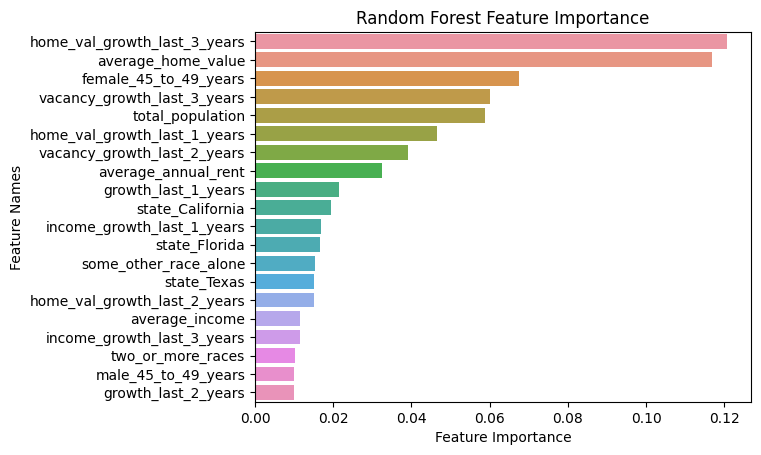

In [25]:
feature_names = ex_train.columns
importances = rf_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
rf_df = pd.DataFrame(data)
rf_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
rf_df = rf_df.head(20)

sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)



plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')


VERSUS HYPERPARAMATER TUNED

In [26]:
%store -r rf_params

In [27]:
rf_params

{'rf__n_estimators': 150,
 'rf__max_depth': 25,
 'rf__criterion': 'friedman_mse',
 'pca__n_components': 19}

In [28]:
if sum([1 if 'pca__' in x else 0 for x in rf_params]) > 0:
    steps = [('pca', PCA(n_components = rf_params['pca__n_components'])), 
             ('rf', ens.RandomForestRegressor(n_estimators = rf_params['rf__n_estimators'], 
                                          max_depth = rf_params['rf__max_depth'],
                                          criterion = rf_params['rf__criterion']))]
    model_rf = Pipeline(steps = steps)

    
    
else:
    
    model_rf = ens.RandomForestRegressor(n_estimators = rf_params['n_estimators'], 
                                          max_depth = rf_params['max_depth'],
                                          criterion = rf_params['criterion'])
    
# TRAIN/VALI
rf_fit = model_rf.fit(ex_train, why_train)
rf_preds_tuned = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds_tuned)))
print('mae - ', mae(why_vali, rf_preds_tuned))


rf_train_preds_tuned = model_rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds_tuned)))
print('training mae - ', mae(why_train, rf_train_preds_tuned))

rmse -  0.150790213342913
mae -  0.11730041025372138
training rmse -  0.04408314760045717
training mae -  0.03198890100975216


BUT TUNED RF STILL OVERFITS

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
%store -r ada_params

In [31]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) > 0:
    steps = [('pca', PCA(n_components = ada_params['pca__n_components'])), 
             ('ada', ens.AdaBoostRegressor(n_estimators = ada_params['ada__n_estimators'], 
                                           learning_rate = ada_params['ada__learning_rate']))]
             
    ada = Pipeline(steps = steps)
    
else:
    ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], 
                                learning_rate = ada_params['learning_rate'])

    
    
# TRAIN/VALI
ada_fit = ada.fit(ex_train, why_train)
ada_preds = ada_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, ada_preds)))
print('mae - ', mae(why_vali, ada_preds))
               
    
ada_train_preds = ada.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, ada_train_preds)))
print('training mae - ', mae(why_train, ada_train_preds))

rmse -  0.1324138769183251
mae -  0.1021427770248975
training rmse -  0.10445983275308499
training mae -  0.08449391670827892


SO DOES TUNED ADABOOST; LET'S TRY ADDING EARLY STOPPING

In [32]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) > 0:
    steps = [('pca', PCA(n_components = ada_params['pca__n_components'])), 
             ('ada', ens.AdaBoostRegressor(n_estimators = ada_params['ada__n_estimators'], 
                                           learning_rate = ada_params['ada__learning_rate']))]
             
    ada = Pipeline(steps = steps)
    
else:
    ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], 
                                learning_rate = ada_params['learning_rate'])

    
min_val_error = float('inf')
early_stopping_rounds = 10
n_no_improve = 0
ada = ada.fit(ex_train, why_train)

for i, y_pred in enumerate(ada.staged_predict(ex_train)):
    val_error = mean_squared_error(why_train, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        n_no_improve = 0
    else:
        n_no_improve += 1
        if n_no_improve == early_stopping_rounds:
            print(f"Early stopping at round {i}")
            break

# Use the best model
ada_stopped_preds = ada.predict(ex_vali)
ada_stopped_error = mean_squared_error(why_vali, ada_stopped_preds)

print(ada_stopped_error)

Early stopping at round 86
0.01760021006456069


In [33]:
# ALSO CHECK TEST SINCE VALI WAS USED FOR EARLY STOPPING
mean_squared_error(why_test, ada.predict(ex_test))

0.03907940409431711

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15558/2225046162.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)


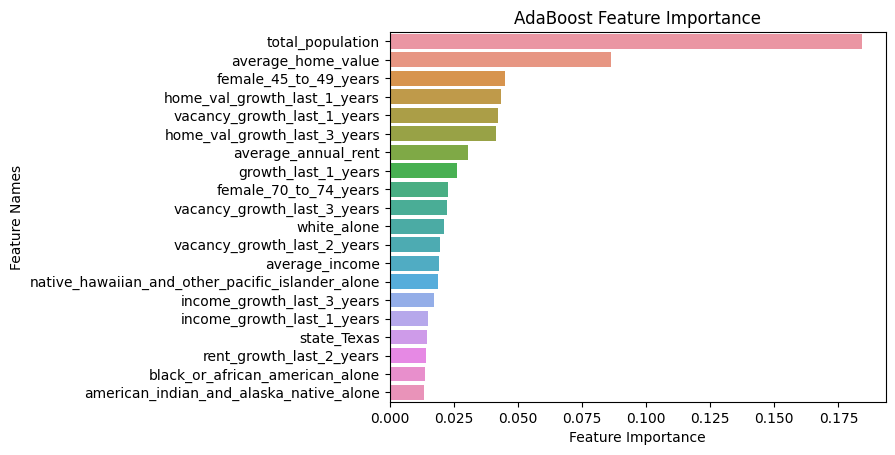

In [34]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) == 0:
    feature_names = ex_train.columns
    importances = ada.feature_importances_
    data = {'feature_names': feature_names, 'feature_importance': importances}
    ada_df = pd.DataFrame(data)
    ada_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    ada_df = ada_df.head(20)

    sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)

    
    plt.title('AdaBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

In [35]:
%store -r xgboost_params

In [36]:
xgboost_params

{'scale_pos_weight': 0.25, 'max_depth': 5, 'eta': 0.2}

In [37]:
# NEED THESE AS FLOATS
common_columns = ['average_annual_rent', 'average_home_value', 'average_income']

ex_train[common_columns] = ex_train[common_columns].astype(float)
ex_vali[common_columns] = ex_vali[common_columns].astype(float)
ex_test[common_columns] = ex_test[common_columns].astype(float)



if sum([1 if 'pca__' in x else 0 for x in xgboost_params]) > 0:
    steps = [('pca', PCA(n_components = xgboost_params['pca__n_components'])), 
             ('xg', XGBRegressor(scale_pos_weight = xgboost_params['xg__scale_pos_weight'],
                                  max_depth = xgboost_params['xg__max_depth'], 
                                  eta = xgboost_params['xg__eta']))]
             
    xg = Pipeline(steps = steps)
    
else:
    xg = XGBRegressor(scale_pos_weight = xgboost_params['scale_pos_weight'],
                  max_depth = xgboost_params['max_depth'], 
                  eta = xgboost_params['eta'])

# TRAIN/VALI
xg_fit = xg.fit(ex_train, why_train)
xg_preds = xg_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, xg_preds)))
print('mae - ', mae(why_vali, xg_preds))


xg_train_preds = xg.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, xg_train_preds)))
print('training mae - ', mae(why_train, xg_train_preds))

rmse -  0.13363459797083233
mae -  0.10196472348350143
training rmse -  0.03617984663882522
training mae -  0.02781271433299624


LET'S STOP ON XGBOOST TOO

In [38]:
# Apply StandardScaler and PCA transformations separately
scaler = StandardScaler()
pca = PCA(n_components=xgboost_params['pca__n_components']) if 'pca__n_components' in xgboost_params else None

# Fit and transform the training data
# REMOVING FOR NOW BECAUSE PCA NOT USED
X_train_scaled = scaler.fit_transform(ex_train)
X_vali_scaled = scaler.transform(ex_vali)
X_test_scaled = scaler.transform(ex_test)

if pca:
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_vali_pca = pca.transform(X_vali_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'scale_pos_weight': xgboost_params['xg__scale_pos_weight'],
    'max_depth': xgboost_params['xg__max_depth'],
    'eta': xgboost_params['xg__eta']
    }
else:
    X_train_pca = X_train_scaled
    X_vali_pca = X_vali_scaled
    X_test_pca = X_test_scaled
    
    params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'scale_pos_weight': xgboost_params['scale_pos_weight'],
    'max_depth': xgboost_params['max_depth'],
    'eta': xgboost_params['eta']
    }

# Use PCA-transformed data for XGBoost training
dtrain = xgb.DMatrix(X_train_pca, label=why_train)
dval = xgb.DMatrix(X_vali_pca, label=why_vali)
dtest = xgb.DMatrix(X_test_pca, label=why_test)

evals = [(dtrain, 'train'), (dval, 'eval')]
xgboost_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=evals
)

xg_stopped_preds = xgboost_model.predict(dval)
xg_stopped_error = mean_squared_error(why_vali, xg_stopped_preds)

print(xg_stopped_error)


[0]	train-rmse:0.27626	eval-rmse:0.16690
[1]	train-rmse:0.22950	eval-rmse:0.14293
[2]	train-rmse:0.19289	eval-rmse:0.12658
[3]	train-rmse:0.16489	eval-rmse:0.11953
[4]	train-rmse:0.14302	eval-rmse:0.11558
[5]	train-rmse:0.12665	eval-rmse:0.11439
[6]	train-rmse:0.11387	eval-rmse:0.11487
[7]	train-rmse:0.10394	eval-rmse:0.11740
[8]	train-rmse:0.09698	eval-rmse:0.11827
[9]	train-rmse:0.09143	eval-rmse:0.11884
[10]	train-rmse:0.08721	eval-rmse:0.12245
[11]	train-rmse:0.08344	eval-rmse:0.12458
[12]	train-rmse:0.08056	eval-rmse:0.12496
[13]	train-rmse:0.07863	eval-rmse:0.12568
[14]	train-rmse:0.07683	eval-rmse:0.12641
0.01622807281895021


In [39]:
# DOUBLE CHECKING TEST
print(mean_squared_error(why_test, xgboost_model.predict(dtest)))

0.03917119478840096


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15558/2668510930.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)


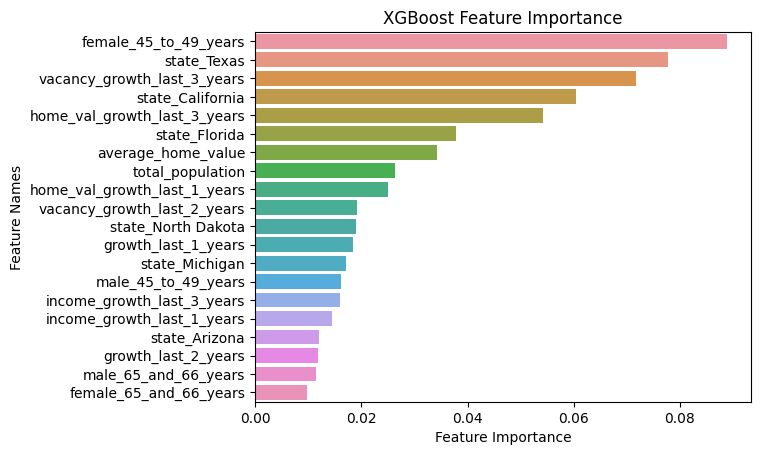

In [40]:
if sum([1 if 'pca__' in x else 0 for x in xgboost_params]) == 0:
    feature_names = ex_train.columns
    importances = xg_fit.feature_importances_
    data = {'feature_names': feature_names, 'feature_importance': importances}
    xg_df = pd.DataFrame(data)
    xg_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    xg_df = xg_df.head(20)

    sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)

   
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

In [41]:
# SO THE TWO EARLY STOPPED BOOSTED MODELS WERE ACTUALLY PRETTY DOPE; THEY'RE SUPER CLOSE SO LET'S AVERAGE THEM
# AS OUR "CANONICAL" PREDS (I'VE SEEN BOTH WIN IN TESTING, SO I'D RATHER OPT FOR THE ENSEMBLE)


canon_preds = [(x + y)/2 for x, y in zip(ada_stopped_preds, xg_stopped_preds)]

vali['predicted_roi'] = canon_preds

In [42]:
pred_check = vali.sort_values(by = 'predicted_roi', ascending = False)
pred_check = pred_check.drop(columns = [x for x in df.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and\
                                        'roi' not in x])


In [43]:
df_ec = vali.copy()
df_ec['error'] = round(df_ec['predicted_roi'] - df_ec['roi'], 3)

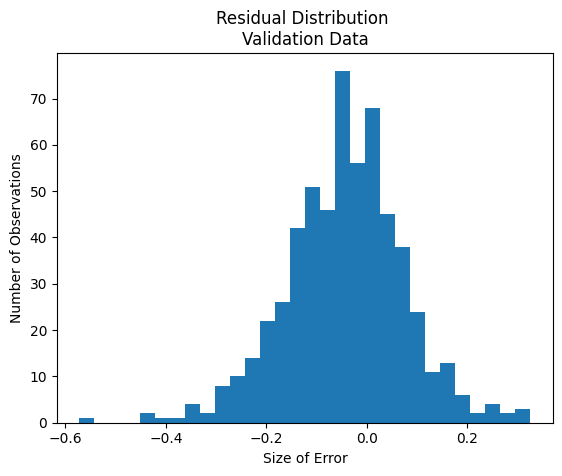

In [44]:
plt.hist(df_ec['error'], bins = 30)
plt.title("Residual Distribution \nValidation Data")
plt.xlabel("Size of Error")
plt.ylabel("Number of Observations")
plt.savefig("Model_Residuals")

NOW LET'S CHECK WHAT WOULD HAVE HAPPENED IF WE HAD USED THE MODEL TO IDENTIFY TOP CANDIDATES IN THE LATEST YEAR OF TESTABLE DATA. I CONSIDER ANY CANDIDATE IDENTIFIED THAT WOULD HAVE PERFORMED BETTER THAN AVERAGE ACCEPTABLE (THRESHOLD IN CELL BELOW). THIS IS AN IMPORTANT MARKER SINCE IT'S HOW WE WOULD HAVE IDENTIFIED A PLACE TO BUY, SO HONESTLY THIS IS MORE CRUCIAL THAN TYPICAL ERROR. USING BUDGET CONSTRAINTS WITH A LITTLE MORE WIGGLE ROOM

In [45]:
print('predicted roi mean - ', pred_check[pred_check['average_home_value'] <= 250000]['predicted_roi'].mean())
print('roi mean - ', pred_check[pred_check['average_home_value'] <= 250000]['roi'].mean())

predicted roi mean -  0.26053213406765885
roi mean -  0.32721999999999996


In [46]:
opzones = list(set(df_opzones['County'].values.tolist()))
opzones_formatted = [x for x in pred_check['place'] if any(y in x for y in opzones)]
pred_check = pred_check[pred_check['place'].isin(opzones_formatted)]
pred_check_budget = pred_check[pred_check['average_home_value'] <= 250000]

In [47]:
pred_check_budget.head(25)

,year,average_annual_rent,place,average_home_value,total_population,roi,predicted_roi
6363,2018,10260.48,Franklin County - Ohio,232311.34,1310300,0.3884,0.422802
6062,2018,10025.40,Kent County - Delaware,245762.20,178550,0.3013,0.407436
6417,2018,11234.88,Cumberland County - Pennsylvania,249294.34,251423,0.2256,0.404584
6071,2018,11626.20,Duval County - Florida,247636.46,950181,0.3387,0.404110
6478,2018,11233.08,Ector County - Texas,180471.85,162124,0.5176,0.403282
6284,2018,9915.12,Bernalillo County - New Mexico,248524.04,678701,0.3330,0.395919
6386,2018,10040.16,Cleveland County - Oklahoma,210344.53,281669,0.2978,0.392740
6511,2018,8398.32,Lynchburg city - Virginia,198371.69,82126,0.2150,0.381394
6261,2018,10263.60,Douglas County - Nebraska,223652.13,566880,0.3811,0.378311
6488,2018,10189.32,Lubbock County - Texas,183882.28,307412,0.4110,0.374981


In [48]:
pred_check_budget.sort_values(by = 'roi', ascending = False).head(25)

,year,average_annual_rent,place,average_home_value,total_population,roi,predicted_roi
6111,2018,8761.68,Canyon County - Idaho,227374.39,223499,0.8293,0.257230
6094,2018,9575.40,Clayton County - Georgia,135140.46,289615,0.7434,0.309837
6073,2018,10872.96,Hernando County - Florida,172689.38,190865,0.6291,0.316343
6509,2018,9790.44,Rockingham County - Virginia,247505.57,81244,0.5910,0.243680
6338,2018,9213.48,Johnston County - North Carolina,189499.79,202675,0.5906,0.193837
6004,2018,10498.20,Pinal County - Arizona,219389.08,447138,0.5821,0.372221
6196,2018,10295.52,Wicomico County - Maryland,201566.41,103195,0.5582,0.319307
6464,2018,7427.40,Putnam County - Tennessee,193730.28,78843,0.5495,0.281496
6001,2018,8128.68,Mohave County - Arizona,211782.76,209550,0.5481,0.261406
6053,2018,8303.52,Pueblo County - Colorado,198455.32,167529,0.5464,0.255904


In [49]:
[place for place in pred_check_budget.head(25)['place'].values.tolist() if \
 place in pred_check_budget.sort_values(by = 'roi', ascending = False).head(25)['place'].values.tolist()]

['Ector County - Texas', 'Pinal County - Arizona', 'Potter County - Texas']

In [50]:
# LEAVE OUT TEST FOR VALIDATION FOR EARLY STOPPING
ex_total = pd.concat([ex_train, ex_vali])
why_total = pd.concat([why_train, why_vali])

In [51]:
df_latest = df_latest.dropna()
ex_serving = df_latest.drop(columns = ['year', 'place'])
ex_serving_scaled = std_scl.fit_transform(ex_serving)

In [52]:
ada = ada.fit(ex_total, why_total)

for i, y_pred in enumerate(ada.staged_predict(ex_test)):
    val_error = mean_squared_error(why_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        n_no_improve = 0
    else:
        n_no_improve += 1
        if n_no_improve == early_stopping_rounds:
            print(f"Early stopping at round {i}")
            break

In [53]:
# DOUBLE CHECK TEST ERROR - HIGHER THAN VALI (MAKES SENSE), BUT REASONABLE
ada_test_preds = ada.predict(ex_test)
ada_test_error = mean_squared_error(why_test, ada_test_preds)

print(ada_test_error)

0.027659610591526225


In [54]:
# Use the best model
ada_serve_preds = ada.predict(ex_serving)

In [55]:
dserve = xgb.DMatrix(ex_serving)
dtotal = xgb.DMatrix(ex_total, label=why_total)
dtest = xgb.DMatrix(ex_test, label=why_test)

evals = [(dtotal, 'train'), (dtest, 'eval')]
xgboost_model_final = xgb.train(
    params,
    dtotal,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=evals
)



[0]	train-rmse:0.26703	eval-rmse:0.12684
[1]	train-rmse:0.22320	eval-rmse:0.11946
[2]	train-rmse:0.18947	eval-rmse:0.12099
[3]	train-rmse:0.16351	eval-rmse:0.12628
[4]	train-rmse:0.14378	eval-rmse:0.13391
[5]	train-rmse:0.12822	eval-rmse:0.13916
[6]	train-rmse:0.11666	eval-rmse:0.14509
[7]	train-rmse:0.10804	eval-rmse:0.14976
[8]	train-rmse:0.10117	eval-rmse:0.15369
[9]	train-rmse:0.09628	eval-rmse:0.15743
[10]	train-rmse:0.09168	eval-rmse:0.15979
[11]	train-rmse:0.08803	eval-rmse:0.16095


In [56]:
# SAME HERE
xg_test_preds = xgboost_model_final.predict(dtest)
xg_test_error = mean_squared_error(why_test, xg_test_preds)

print(xg_test_error)

0.025904295957842664


In [57]:
xg_serve_preds = xgboost_model_final.predict(dserve)

In [58]:
ensemble_preds = [(x + y)/2 for x, y in zip(ada_serve_preds, xg_serve_preds)]

In [59]:
df_latest['pred'] = ensemble_preds

In [60]:
# MAKE PLACE EASIER FOR API I.E. NO SPACES; WANNA KEEP IN ORIGINAL DF IN CASE I WANT FURTHER ANALYSIS
df_save = df_latest.copy()
df_save['place'] = df_save['place'].apply(lambda x: re.sub(' ', '.', 
                                                           re.sub('St.', 'Saint', 
                                                                  re.sub(' - ', '.', x))))

In [61]:
# NO NEED TO KEEP STATE DUMMIES FOR API; STATE ALREADY HUMAN-READABLE WITH PLACE COLUMN
df_save = df_save.drop(columns = [x for x in df_save.columns if 'state_' in x])

In [62]:
df_save.to_csv("latest_yrs_w_preds_county.csv", index = False)

In [63]:
df_save

,year,average_annual_rent,place,rent_growth_last_1_years,rent_growth_last_2_years,rent_growth_last_3_years,average_home_value,home_val_growth_last_1_years,home_val_growth_last_2_years,home_val_growth_last_3_years,...,female_67_to_69_years,female_70_to_74_years,female_75_to_79_years,female_80_to_84_years,female_85_years_and_over,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years,pred
3793,2022,12343.32,Baldwin.County.Alabama,0.000000,0.126960,0.094010,372039.09,0.189272,0.333363,0.279621,...,0.026060,0.028072,0.024238,0.012441,0.014795,0.252799,-0.056205,-0.097447,-0.186241,0.340150
3794,2022,6386.64,Calhoun.County.Alabama,-0.052197,-0.026629,-0.043905,174555.85,0.068918,0.139640,0.112650,...,0.027524,0.021133,0.022420,0.010182,0.010148,0.144304,-0.105062,-0.152753,-0.153509,0.290206
3795,2022,7021.20,Etowah.County.Alabama,0.092420,0.164981,0.203711,210205.40,0.264209,0.402089,0.460608,...,0.025958,0.024435,0.023252,0.011660,0.008769,0.161328,-0.187361,-0.146870,-0.010464,0.233170
3796,2022,7715.04,Houston.County.Alabama,0.015591,0.081283,0.125698,231844.62,0.201406,0.309785,0.189231,...,0.022308,0.027526,0.019541,0.014443,0.013009,0.155158,0.358879,-0.074591,-0.108395,0.278897
3797,2022,11040.00,Jefferson.County.Alabama,0.104415,0.203905,0.238573,309740.88,0.158403,0.316925,0.261729,...,0.018882,0.023585,0.018530,0.010448,0.012870,0.124891,-0.011312,-0.143355,-0.139014,0.302479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4352,2022,6201.12,Carolina.Municipio.Puerto.Rico,-0.103392,-0.075282,-0.117871,186807.03,0.304925,0.189951,0.212950,...,0.019291,0.036775,0.039315,0.024668,0.019641,0.155512,-0.256845,-0.183327,-0.317069,0.232033
4353,2022,9361.08,Guaynabo.Municipio.Puerto.Rico,0.000000,0.093528,0.125657,314576.61,0.239095,0.312710,0.377414,...,0.020526,0.035292,0.033394,0.028577,0.016270,0.134428,-0.177263,-0.384312,-0.292108,0.263558
4354,2022,4752.24,Mayagüez.Municipio.Puerto.Rico,0.000000,0.182079,0.214208,132560.47,-0.053906,0.011691,0.055784,...,0.022717,0.027249,0.037998,0.021102,0.031710,0.269384,-0.130908,-0.029580,-0.116206,0.185150
4355,2022,4887.72,Ponce.Municipio.Puerto.Rico,0.021851,0.261842,0.117111,114013.61,-0.017000,-0.034442,-0.034445,...,0.028243,0.035614,0.031694,0.024255,0.018344,0.195312,-0.171579,-0.039047,-0.021824,0.251114
